1. Introduction
2. Data import and exploration
3. Data preprocessing
4. Modelling
    4.1. Linear regression
        4.2. Random Forest
        4.3. XGBOOST
        4.4. CV with XGboost
Import dependencies

Import datasets

Data preparation

3.1. Pclass
3.2. Sex
3.3. Age
      3.3.1. [Derived] ageband
3.4. SibSp
3.5. Parch
      3.5.1 [Derived] familysize (SibSp+Parch)
      3.5.2 [Derived] alone (lone travellers)
3.6. Name
      3.6.1 [Derived] high_status
3.7. Fare
3.8. Cabin
      3.8.1 [Derived] first_letter_cabin
3.9. Embarked
 

Dealing with missing data
4.1 Dropping
4.2 Imputing
4.2. One-hot encoding
 
Classification
5.1 Logistic regression
5.2 Linear SVC
5.3 KNearest neighbors
5.4 SVC
5.5 Random Forest Classifier
 

Results




1. Intro about the data
2. Data import and exploration (train) [take ideas from my github] - remember about outliers
3. Data preprocessing (one-hot, regularisation, etc)
4. Feature engineering
5. Model selection and Rationale
5.1. Shallow learning
5.2. Deep learning (see tensorflow models I did for andrew as an inspiration)

6. Compare results with the leaderboard, submit results.

#### Ideas: 
    - [DONE] Consider converting time to a continuous variable that'd take into account that 00:01 is closer to 23:59 than to 00:10 ( test accuracy with and without it)
    
    - Consider doing the deep learning spiel in a separate file, using a preprocessed data achieved in this file (prob more efficient for use in floydhub)
    - Consider using tools for finding sensible parameters 
    
    - Consider making predictions for registered an casual separately, and then combining the scores.
    - Consider taking log of dependent variables
    - Consider removing outliers from 'count'
    - check if you're actually using all imported things
    - try out random forest and other models (for comparison)
    
    
    tweaks to try: 
    
    - don't use cyclical for days of the week.
  

#### 1. Introduction

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression
import xgboost as xg
from sklearn.ensemble import RandomForestRegressor


Variables included in the data: 

    datetime   - hourly date + timestamp  
    
    season     -  1 = spring,
                  2 = summer,
                  3 = fall,
                  4 = winter 
                  
    holiday    - whether the day is considered a holiday
    
    workingday - whether the day is neither a weekend nor holiday
    
    weather    -  1: Clear, Few clouds, Partly cloudy, Partly cloudy 
                  2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
                  3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
                 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
                 
    temp       - temperature in Celsius
    
    atemp      - "feels like" temperature in Celsius
    
    humidity   - relative humidity
    
    windspeed  - wind speed
    
    casual     - number of non-registered user rentals initiated
    
    registered - number of registered user rentals initiated
    
    count      - number of total rentals

#### 2. Data import and exploration

In [4]:
data = pd.read_csv("./data/train.csv")

In [5]:
data.head()


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


#### 3. Preprocessing and feature extraction

   

Let's import the train and test datasets.

In [6]:
train_df = pd.read_csv("./data/train.csv") 
test_df = pd.read_csv("./data/test.csv") 
combined_df = [train_df, test_df] #combined datasets - I'll use this in loops replacing values in both datasets 

Let's look at descriptive statistics of this dataset to see if there are any outliers, or data that seems to be erroneous entries.

In [7]:
train_df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [8]:
# The relative humidity level seems odd and is suggestive of presence of outliers. I'll look into this later.

In [9]:
train_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
datetime      6493 non-null object
season        6493 non-null int64
holiday       6493 non-null int64
workingday    6493 non-null int64
weather       6493 non-null int64
temp          6493 non-null float64
atemp         6493 non-null float64
humidity 

Excellent, no missing data!

Before we go on and transform the data, let's run a Pearson correlation matrix to see if there are any bivariate correlations worth looking into in more detail.

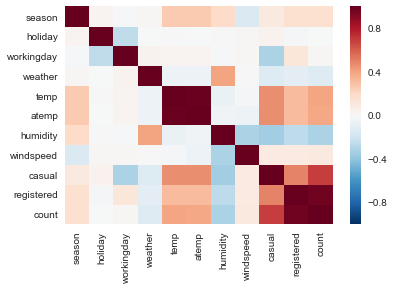

In [10]:
corr = train_df.corr(method='pearson')
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

As one might expect, count of bike-users correlates with air temperature (and "feels like"-temperature), humidity (which is itself highly correlated with the categorical variable describing the weather).

Let's look at some of the variables individually to understand the data better and see if there are any outliers

(A) datetime

In [11]:
train_df["datetime"].head()

0    2011-01-01 00:00:00
1    2011-01-01 01:00:00
2    2011-01-01 02:00:00
3    2011-01-01 03:00:00
4    2011-01-01 04:00:00
Name: datetime, dtype: object

The format of the datetime variable is not suitable for analysis - let's use pandas to extract days of the month/week, years, and hours from it.

Additionally, I'll encode hours, months, and days of the week to preserve their cyclical nature. 
I got this idea from https://datascience.stackexchange.com/questions/5990/what-is-a-good-way-to-transform-cyclic-ordinal-attributes
  

In [12]:
for df in combined_df:
    date = pd.DatetimeIndex(df['datetime'])

    df['month'] = date.month
    df['year'] = date.year
    df['hour'] = date.hour
    df['day_of_week'] = date.dayofweek

    # # Let's encode hours, months, and days of the week to preserve their cyclical nature 
    df['hour_sin'] = np.sin(df.hour*(2.*np.pi/24))
    df['hour_cos'] = np.cos(df.hour*(2.*np.pi/24))

    df['dow_sin'] = np.sin(df.day_of_week*(2.*np.pi/7))
    df['dow_cos'] = np.cos(df.day_of_week*(2.*np.pi/7))

    df['month_sin'] = np.sin((df.month-1)*(2.*np.pi/12))
    df['month_cos'] = np.cos((df.month-1)*(2.*np.pi/12))
    
    


    df.drop('datetime', axis = 1, inplace = True)


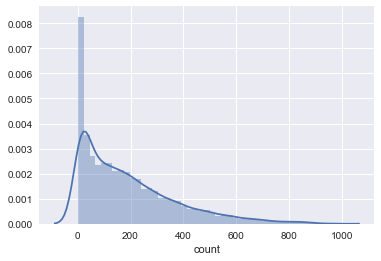

In [13]:
sns.distplot(train_df["count"])


The dependent variable is quite skewed - I think that log1p-transforming it is a sensible option (as disproportionately many values are 0).

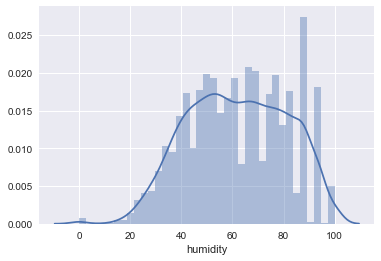

In [14]:
sns.distplot(train_df["humidity"])


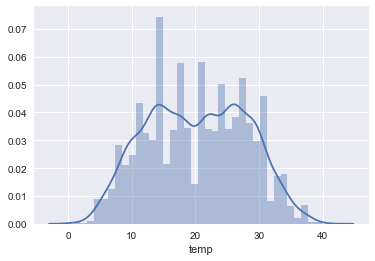

In [15]:
sns.distplot(train_df["temp"])


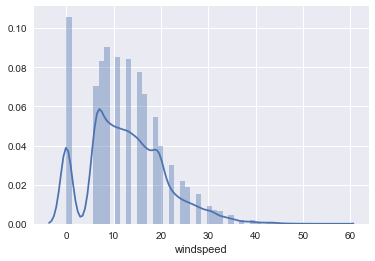

In [16]:
sns.distplot(train_df["windspeed"])


Windspeed has an odd distribution, too. Windspeed of 0 is overrepresented in this sample, although it's generally unlikely to occur in real life [citation needed]. This may mean the device collecting the data is very insensitive to wind slower than 6km/h and assigning value of 0 to such measurements. 

I could imput the values for windspeed<=6, but looking back at the correlation matrix, this variable might not be particularly useful to include in the models. I might abandon this feature for now (and perhaps come crawling back when my models' performance turns out to be terrible).

Let's explore how different months, days, and time of day influence demand. 

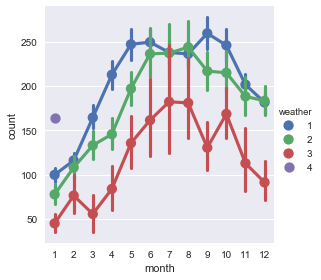

In [17]:
g= sns.factorplot(data = train_df,
               x = "month",
               y = "count",
               hue = "weather",
               ) 

People are more likely to cycle during warmer months - that makes intuitive sense.


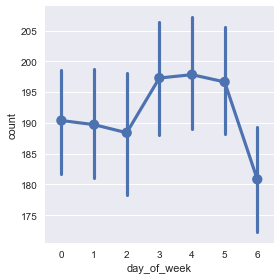

In [18]:
sns.factorplot(data = train_df,
               x = "day_of_week",
               y = "count", 
#              hue = "weather", #too noisy to be informative
               ) 

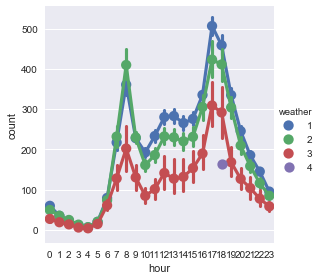

In [19]:
sns.factorplot(data = train_df,
               x = "hour",
               y = "count", 
               hue = "weather",
               ) 

The peaks in demand happen during the communiting hours - I'm curious about how the demand over cyclical timeframes varies for the two casual and registered user cohorts; casual users may represent vastly different demographics and hence bike usage patterns - let's find out!

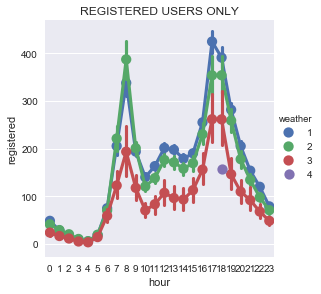

In [20]:
# REGISTERED USERS
sns.factorplot(data = train_df,
                  x = 'hour',
                  y = "registered", 
                  hue = "weather",
            
               )

sns.plt.title('REGISTERED USERS ONLY')




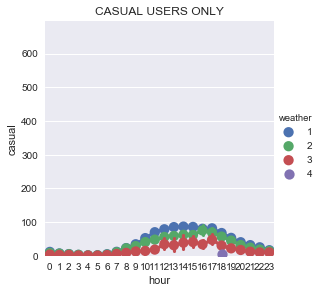

In [21]:
g= sns.factorplot(data = train_df,
               x = 'hour',
               y = "casual",
                hue = "weather"
               ) 
(g.set(ylim=(0, train_df.registered.quantile(0.99
                                            ))))

sns.plt.title('CASUAL USERS ONLY')


It appears that registered users and casual users have different usage patterns of city bikes.
Registered users use rental bikes disproportionately more during commuting hours (7-8am and 5-7pm), whereas casual cyclists' hourly usage usage patterns are more regular, peaking between 12pm and 4pm.

I think that observation in itself warrants running two separate models for casual and registered users and using the sum of the two predictions as the final 'count' dependent variable. Nonetheless, let's see if we can observe differences in usage patterns in weekly (day_of_week), monthly (month) timeframes. 

Additionally, we'll look at the relationship between the temperature and the demand for these two user groups. 

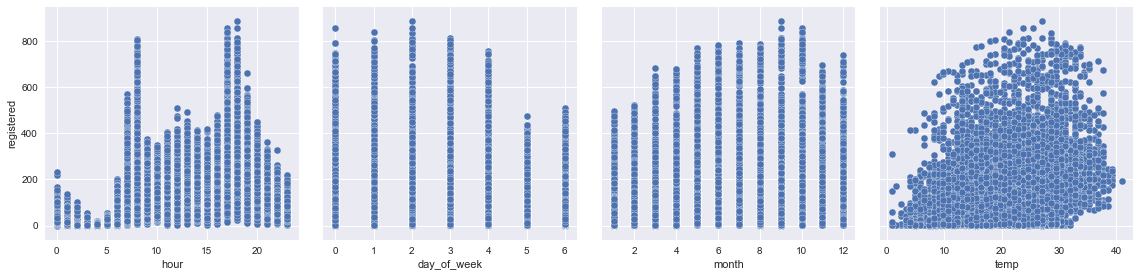

In [22]:
sns.pairplot(train_df, x_vars=['hour', 'day_of_week','month', 'temp'], y_vars='registered', diag_kind = 'hist', palette="Set3", aspect=1, size=4)

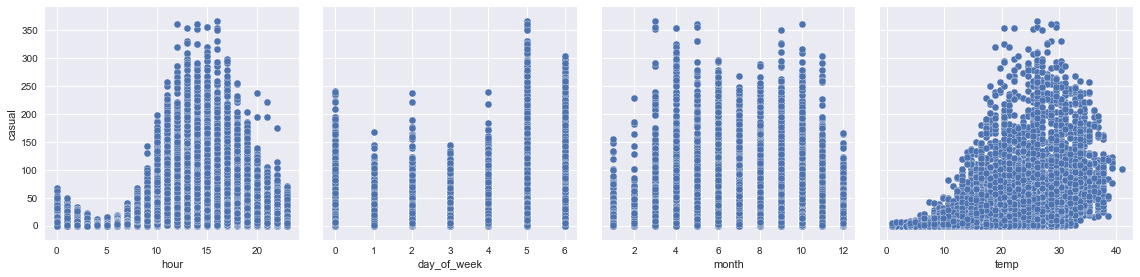

In [23]:
sns.pairplot(train_df, x_vars=['hour', 'day_of_week','month', 'temp'], y_vars='casual', palette="Set3",aspect=1, size=4)


Awesome! Two additional things I noticed from the comparison between the two user groups is:

- There is an apparent difference between demand on workdays vs weekends (casual users appear to be more keen to cycle on the weekends than on the workdays - the reverse is true for registered users). 
- Registered users appear to be less sensitive to low temperatures (no wonder; cycling commuters are a resilient bunch!)

Let's one-hot encode some categorical variables.

In [24]:
def onehot_encode(df, varlist):
    
        for var in varlist:
            dummies =  pd.get_dummies(df[var], prefix=var, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False)
            df = pd.concat([df, dummies], axis=1)
            df.drop(var, inplace = True, axis=1)
        return df
    
    
to_onehot_encode = ['season',
                    'weather',
                    'year']

train_df = onehot_encode(df = train_df, varlist = to_onehot_encode)
test_df = onehot_encode(df = test_df, varlist = to_onehot_encode)

#let's drop the obsolete one-hot-encoded features and other unnecessary variables
to_drop = ['atemp', 'windspeed', 'month','hour','day_of_week']
train_df.drop(to_drop, inplace = True, axis = 1)
test_df.drop(to_drop, inplace = True, axis = 1)

In [25]:
train_df.keys()

Index(['holiday', 'workingday', 'temp', 'humidity', 'casual', 'registered',
       'count', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin',
       'month_cos', 'season_1', 'season_2', 'season_3', 'season_4',
       'weather_1', 'weather_2', 'weather_3', 'weather_4', 'year_2011',
       'year_2012'],
      dtype='object')

In [26]:
test_df.keys()

Index(['holiday', 'workingday', 'temp', 'humidity', 'hour_sin', 'hour_cos',
       'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'season_1', 'season_2',
       'season_3', 'season_4', 'weather_1', 'weather_2', 'weather_3',
       'weather_4', 'year_2011', 'year_2012'],
      dtype='object')

Let's now split the train data into two datasets - one containing dependent features we want to predict (Y) and the other one containing our independent features only (X). After that I'll split these into train and validation sets using sklearn's train_test_split.

In [27]:

Y = train_df[["count","registered","casual"]]
X = train_df.drop(["count","registered","casual"], axis = 1)

#I'll use these for measuring accuracy of the models 
X_train, X_validate, y_train, y_validate = train_test_split(train_df.drop(["count","registered","casual"], axis = 1),train_df[["count","registered","casual"]], test_size=0.3, random_state=2)


#### 4. Modelling

I'm going to use a few model types to probe for the most promising architecture for this problem.

I'll test the following regressors:

    Linear regression
    AdaBoost regressor
    Random forest 
    xgboost
    
Let's implement the scoring function Kaggle uses for this competition so I can compare my model's performance with the public leaderboard before submitting my solutions.

In [28]:
def rmsle(h, y): 
    """
    Compute the Root Mean Squared Log Error for hypothesis h and targets y

    Args:
        h - numpy array containing predictions with shape (n_samples, n_targets)
        y - numpy array containing targets with shape (n_samples, n_targets)
    """
    return np.sqrt(np.square(np.log(h + 1) - np.log(y + 1)).mean())

# Source: https://www.kaggle.com/wiki/RootMeanSquaredLogarithmicError


I'm guessing it's unlikely there's a clear linear relationship between the independent variables and the dependent variable, but let's start off with running a linear regression model to find out.

In [29]:
reg_casual = LinearRegression()
reg_registered = LinearRegression()

reg_casual.fit(X = X_train, y = np.log1p(y_train['casual']))
reg_registered.fit(X = X_train, y = np.log1p(y_train['registered']))

# Make predictions for total count ('count') based on a sum of predicted casual and registered users
pred_train = np.exp(reg_registered.predict(X= X_train)) + np.exp(reg_casual.predict(X= X_train))
pred_validate = np.exp(reg_registered.predict(X= X_validate)) + np.exp(reg_casual.predict(X= X_validate))

print("LINEAR REGRESSION\n"+"-"*40)
print("RMSLE Train: ",rmsle(pred_train,np.exp(np.log1p(y_train['count']))))
print("RMSLE Validation: ",rmsle(pred_validate,np.exp(np.log1p(y_validate['count']))))


LINEAR REGRESSION
----------------------------------------
RMSLE Train:  0.835579345474
RMSLE Validation:  0.811100444628


I guess that's an okay good result for a linear regression model in this context, but still nowhere near the kind of score I should be aiming at.

In [30]:
from sklearn.ensemble import AdaBoostRegressor

ada_reg_casual = AdaBoostRegressor(n_estimators=1000, learning_rate=1.0, loss='linear')
ada_reg_registered = AdaBoostRegressor(n_estimators=1000, learning_rate=1.0, loss='linear')

ada_reg_casual.fit(X = X_train, y = np.log1p(y_train['casual']))
ada_reg_registered.fit(X = X_train, y = np.log1p(y_train['registered']))

pred_train =  np.exp(ada_reg_registered.predict(X_train)) + np.exp(ada_reg_casual.predict(X_train))
pred_validate =  np.exp(ada_reg_registered.predict(X_validate)) + np.exp(ada_reg_casual.predict(X_validate))

print("ADABOOST REGRESSOR\n"+"-"*40)
print("RMSLE Train: ",rmsle(pred_train,np.exp(np.log1p(y_train['count']))))
print("RMSLE Validation: ",rmsle(pred_validate,np.exp(np.log1p(y_validate['count']))))





ADABOOST REGRESSOR
----------------------------------------
RMSLE Train:  0.655296476683
RMSLE Validation:  0.652501309944


Adaboost showed a substantial improvement over the linear regression, but I didn't have luck making the score better with manual hyperparameter tuning and feature engineering. Let's see how Random Forest and xgboost do in this setting! 

In [33]:
rf_casual = RandomForestRegressor(n_estimators=1000, max_features=10)
rf_registered = RandomForestRegressor(n_estimators=1000, max_features=10)

rf_casual.fit(X = X_train, y = np.log1p(y_train['casual']))
rf_registered.fit(X = X_train, y = np.log1p(y_train['registered']))

pred_train =  np.exp(rf_registered.predict(X_train)) + np.exp(rf_casual.predict(X_train))
pred_validate =  np.exp(rf_registered.predict(X_validate)) + np.exp(rf_casual.predict(X_validate))

print("RANDOM FOREST REGRESSOR\n"+"-"*40)
print("RMSLE Train: ",rmsle(pred_train,np.exp(np.log1p(y_train['count']))))
print("RMSLE Validation: ",rmsle(pred_validate,np.exp(np.log1p(y_validate['count']))))




RANDOM FOREST REGRESSOR
----------------------------------------
RMSLE Train:  0.119081605768
RMSLE Validation:  0.276824426947


The score my random forest model got on Kaggle is 0.408 - which is... pretty good!

Let's see if I can top this with xgboost. :)

In [34]:
#saving my submission file
test_pred1 = (np.exp(rf_casual.predict(test_df)) + np.exp(rf_registered.predict(test_df)))

df = pd.read_csv("./data/test.csv")['datetime']
df = pd.DataFrame({'datetime':df, 'count':test_pred1})
df.to_csv('submission_random_forest', index = False, columns=['datetime','count'])



In [35]:
xg_casual = xg.XGBRegressor(max_depth=8,min_child_weight=4,gamma=0,colsample_bytree=0.9,subsample=0.9) 
xg_registered = xg.XGBRegressor(max_depth=8,min_child_weight=4,gamma=0,colsample_bytree=0.9,subsample=0.9) 


'''XGBOOST
----------------------------------------
RMSLE Train:  0.15522870962
RMSLE Validation:  0.26488524148'''
    
    
xg_casual.fit(X = X_train, y = np.log1p(y_train['casual']))
xg_registered.fit(X = X_train, y = np.log1p(y_train['registered']))

pred_train =  np.exp(xg_registered.predict(X_train)) + np.exp(xg_casual.predict(X_train)) 
pred_validate =  np.exp(xg_registered.predict(X_validate)) + np.exp(xg_casual.predict(X_validate))

print("XGBOOST\n"+"-"*40)
print("RMSLE Train: ",rmsle(pred_train,np.exp(np.log1p(y_train['count']))))
print("RMSLE Validation: ",rmsle(pred_validate,np.exp(np.log1p(y_validate['count']))))

XGBOOST
----------------------------------------
RMSLE Train:  0.15522870962
RMSLE Validation:  0.26488524148


This one got 0.413 on Kaggle - interestingly, it has a lower RSMLE validation error than Random Forest regressor.
Let's save this one submission and see if I can improve this score with gridsearchCV.

In [36]:
test_pred1 = (np.exp(xg_casual.predict(test_df)) + np.exp(xg_registered.predict(test_df)))

df = pd.read_csv("./data/test.csv")['datetime']
df = pd.DataFrame({'datetime':df, 'count':test_pred1})

df.to_csv('submission_xgboost', index = False, columns=['datetime','count'])

In [39]:
parameters = {#'learning_rate': 0.07,
              'subsample': 1,
              'max_depth': 6,
              'min_child_weight': 5,
              'n_estimators': 1000,
              'seed':0,
              'colsample_bytree': 0.8}



def gridsearch(parameters_tested, x, y):
    
    
    grid_search = GridSearchCV(estimator = xg.XGBRegressor(**parameters), 
                                param_grid = parameters_tested, 
                                n_jobs = 4,
                                iid = False,
                                cv = 5)

    grid_search.fit(x,y)
    print(grid_search.grid_scores_)
    print(grid_search.best_params_)
    print("\n")
    print(grid_search.best_score_)


Let's run a gridsearch for xgboost

In [40]:
parameters_registered = {#'learning_rate': 0.07,
              'subsample': 0.9,
              'max_depth': 7,
              'min_child_weight': 0,
              'n_estimators': 1000,
              'seed':0,
              'colsample_bytree': 0.7,
              'gamma': 0,
#               'reg_alpha': 100
              'reg_alpha': 4
                        }



param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(0,7,2)
}

gridsearch(param_test1, X_train, y_train['registered']) 

'''
Commented out the following, as it takes a longer while to run.


Optimal values were:
{'max_depth': 7, 'min_child_weight': 0}


{'max_depth': 5, 'min_child_weight': 4}
'''

[mean: 0.93447, std: 0.00597, params: {'max_depth': 3, 'min_child_weight': 0}, mean: 0.93578, std: 0.00694, params: {'max_depth': 3, 'min_child_weight': 2}, mean: 0.93547, std: 0.00749, params: {'max_depth': 3, 'min_child_weight': 4}, mean: 0.93570, std: 0.00695, params: {'max_depth': 3, 'min_child_weight': 6}, mean: 0.95734, std: 0.00519, params: {'max_depth': 5, 'min_child_weight': 0}, mean: 0.95717, std: 0.00524, params: {'max_depth': 5, 'min_child_weight': 2}, mean: 0.95801, std: 0.00517, params: {'max_depth': 5, 'min_child_weight': 4}, mean: 0.95757, std: 0.00499, params: {'max_depth': 5, 'min_child_weight': 6}, mean: 0.95693, std: 0.00647, params: {'max_depth': 7, 'min_child_weight': 0}, mean: 0.95667, std: 0.00622, params: {'max_depth': 7, 'min_child_weight': 2}, mean: 0.95636, std: 0.00613, params: {'max_depth': 7, 'min_child_weight': 4}, mean: 0.95702, std: 0.00549, params: {'max_depth': 7, 'min_child_weight': 6}, mean: 0.95447, std: 0.00772, params: {'max_depth': 9, 'min_chil

/Users/raf/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


"\nCommented out the following, as it takes a longer while to run.\n\n\nOptimal values were:\n{'max_depth': 7, 'min_child_weight': 0}\n\n"

In [42]:
# Updating parameters...

parameters = {#'learning_rate': 0.07,
              'subsample': 1,
              'max_depth': 5,
              'min_child_weight': 4,
              'n_estimators': 1000,
              'seed':0,
              'colsample_bytree': 0.8}



param_test2 = {'gamma':[n/10.0 for n in range(0,6)]}

gridsearch(param_test2, X_train, y_train['registered'])

# Optimal values were:
# {'gamma': 0.0}

#{'gamma': 0.0}


[mean: 0.95801, std: 0.00517, params: {'gamma': 0.0}, mean: 0.95792, std: 0.00516, params: {'gamma': 0.1}, mean: 0.95791, std: 0.00533, params: {'gamma': 0.2}, mean: 0.95789, std: 0.00536, params: {'gamma': 0.3}, mean: 0.95795, std: 0.00530, params: {'gamma': 0.4}, mean: 0.95791, std: 0.00523, params: {'gamma': 0.5}]
{'gamma': 0.0}


0.958011753173


/Users/raf/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [43]:
parameters = {#'learning_rate': 0.07,
              'subsample': 1,
              'max_depth': 5,
              'min_child_weight': 4,
              'n_estimators': 1000,
              'seed':0,
              'colsample_bytree': 0.8}

param_test3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,11)]
}


gridsearch(param_test3, X_train, y_train['registered'])
#Optimal values were:
# {'colsample_bytree': 0.7, 'subsample': 0.9}'''
#{'colsample_bytree': 1.0, 'subsample': 0.9}


[mean: 0.95645, std: 0.00512, params: {'colsample_bytree': 0.6, 'subsample': 0.6}, mean: 0.95709, std: 0.00572, params: {'colsample_bytree': 0.6, 'subsample': 0.7}, mean: 0.95625, std: 0.00535, params: {'colsample_bytree': 0.6, 'subsample': 0.8}, mean: 0.95673, std: 0.00537, params: {'colsample_bytree': 0.6, 'subsample': 0.9}, mean: 0.95750, std: 0.00595, params: {'colsample_bytree': 0.7, 'subsample': 0.6}, mean: 0.95667, std: 0.00519, params: {'colsample_bytree': 0.7, 'subsample': 0.7}, mean: 0.95687, std: 0.00519, params: {'colsample_bytree': 0.7, 'subsample': 0.8}, mean: 0.95700, std: 0.00565, params: {'colsample_bytree': 0.7, 'subsample': 0.9}, mean: 0.95642, std: 0.00507, params: {'colsample_bytree': 0.8, 'subsample': 0.6}, mean: 0.95738, std: 0.00553, params: {'colsample_bytree': 0.8, 'subsample': 0.7}, mean: 0.95742, std: 0.00566, params: {'colsample_bytree': 0.8, 'subsample': 0.8}, mean: 0.95674, std: 0.00466, params: {'colsample_bytree': 0.8, 'subsample': 0.9}, mean: 0.95765, 

/Users/raf/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [54]:
parameters = {#'learning_rate': 0.07,
              'subsample': 0.9,
              'max_depth': 5,
              'min_child_weight': 4,
              'n_estimators': 1000,
              'seed':0,
              'colsample_bytree': 1}

param_test4 = {'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100] }

# gridsearch(param_test4, X_train, y_train['registered'])
# {'reg_alpha': 100}'''

# FINAL PARAMETERS FOR 'REGISTERED' MODEL
# _______________________________________
#
parameters_registered = {#'learning_rate': 0.07,
              'subsample': 0.9,
              'max_depth': 5,
              'min_child_weight': 4,
              'n_estimators': 1000,
              'seed':0,
              'colsample_bytree': 1,
                'reg_alpha': 4}

# gridsearch for 'casual' xgboost model

In [46]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(0,7,2)
}


gridsearch(param_test1, X_train, y_train['casual']) 
# {'max_depth': 5, 'min_child_weight': 2}'''



[mean: 0.90341, std: 0.00500, params: {'max_depth': 3, 'min_child_weight': 0}, mean: 0.90391, std: 0.00452, params: {'max_depth': 3, 'min_child_weight': 2}, mean: 0.90286, std: 0.00472, params: {'max_depth': 3, 'min_child_weight': 4}, mean: 0.90360, std: 0.00482, params: {'max_depth': 3, 'min_child_weight': 6}, mean: 0.91429, std: 0.00616, params: {'max_depth': 5, 'min_child_weight': 0}, mean: 0.91383, std: 0.00567, params: {'max_depth': 5, 'min_child_weight': 2}, mean: 0.91419, std: 0.00534, params: {'max_depth': 5, 'min_child_weight': 4}, mean: 0.91477, std: 0.00557, params: {'max_depth': 5, 'min_child_weight': 6}, mean: 0.91256, std: 0.00754, params: {'max_depth': 7, 'min_child_weight': 0}, mean: 0.91196, std: 0.00831, params: {'max_depth': 7, 'min_child_weight': 2}, mean: 0.91101, std: 0.00816, params: {'max_depth': 7, 'min_child_weight': 4}, mean: 0.91073, std: 0.00882, params: {'max_depth': 7, 'min_child_weight': 6}, mean: 0.90969, std: 0.00658, params: {'max_depth': 9, 'min_chil

/Users/raf/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [48]:
parameters = {#'learning_rate': 0.07,
              'subsample': 0.9,
              'max_depth': 5,
              'min_child_weight': 6,
              'n_estimators': 1000,
              'seed':0,
              'colsample_bytree': 1,
            }

param_test2 = {'gamma':[n/10.0 for n in range(0,6)]}

gridsearch(param_test2, X_train, y_train['casual'])
#{'gamma': 0.4}'''

[mean: 0.91477, std: 0.00557, params: {'gamma': 0.0}, mean: 0.91501, std: 0.00535, params: {'gamma': 0.1}, mean: 0.91513, std: 0.00550, params: {'gamma': 0.2}, mean: 0.91522, std: 0.00550, params: {'gamma': 0.3}, mean: 0.91512, std: 0.00560, params: {'gamma': 0.4}, mean: 0.91516, std: 0.00543, params: {'gamma': 0.5}]
{'gamma': 0.3}


0.915215718847


/Users/raf/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [50]:
parameters = {#'learning_rate': 0.07,
              'subsample': 0.9,
              'max_depth': 5,
              'min_child_weight': 6,
              'n_estimators': 1000,
              'seed':0,
              'colsample_bytree': 1,
            'gamma': 0.3
            }


param_test3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,11)]
}

gridsearch(param_test3, X_train, y_train['casual'])
#{'colsample_bytree': 0.9, 'subsample': 0.7}'''

[mean: 0.91286, std: 0.00613, params: {'colsample_bytree': 0.6, 'subsample': 0.6}, mean: 0.91398, std: 0.00585, params: {'colsample_bytree': 0.6, 'subsample': 0.7}, mean: 0.91347, std: 0.00554, params: {'colsample_bytree': 0.6, 'subsample': 0.8}, mean: 0.91447, std: 0.00714, params: {'colsample_bytree': 0.6, 'subsample': 0.9}, mean: 0.91364, std: 0.00626, params: {'colsample_bytree': 0.7, 'subsample': 0.6}, mean: 0.91274, std: 0.00527, params: {'colsample_bytree': 0.7, 'subsample': 0.7}, mean: 0.91353, std: 0.00594, params: {'colsample_bytree': 0.7, 'subsample': 0.8}, mean: 0.91361, std: 0.00552, params: {'colsample_bytree': 0.7, 'subsample': 0.9}, mean: 0.91504, std: 0.00509, params: {'colsample_bytree': 0.8, 'subsample': 0.6}, mean: 0.91346, std: 0.00510, params: {'colsample_bytree': 0.8, 'subsample': 0.7}, mean: 0.91312, std: 0.00617, params: {'colsample_bytree': 0.8, 'subsample': 0.8}, mean: 0.91513, std: 0.00622, params: {'colsample_bytree': 0.8, 'subsample': 0.9}, mean: 0.91396, 

/Users/raf/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [ ]:
# parameters = {'learning_rate': 0.07,
#               'subsample': 0.7,
#               'max_depth': 5,
#               'min_child_weight': 2,
#               'n_estimators': 1000,
#               'seed':0,
#               'colsample_bytree': 0.9,
#               'gamma': 0.4,
#               'reg_alpha': 100}


param_test4 = {'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100] }

'''gridsearch(param_test4, X_train, y_train['casual'])
{'reg_alpha': 100}'''

In [55]:
# FINAL PARAMETERS FOR 'CASUAL' MODEL
# _______________________________________
parameters_casual = {#'learning_rate': 0.07,
              'subsample': 0.9,
              'max_depth': 5,
              'min_child_weight': 6,
              'n_estimators': 1000,
              'seed':0,
              'colsample_bytree': 1,
            'gamma': 0.3,
    'reg_alpha': 4
            }


In [56]:
# rerun with parameters found through CVsearch

xg_casual = xg.XGBRegressor(**parameters_casual) 
xg_registered = xg.XGBRegressor(**parameters_registered) 


'''XGBOOST
----------------------------------------
RMSLE Train:  0.15522870962
RMSLE Validation:  0.26488524148


with reg_alpha=100:

XGBOOST
----------------------------------------
RMSLE Train:  0.378822606431
RMSLE Validation:  0.383880715462
Kaggle score: 0.48853

with default alpha = 0:

XGBOOST
----------------------------------------
RMSLE Train:  0.103201648233
RMSLE Validation:  0.263449148838
Kaggle score: 0.41308



There's definitely value in reguralization, given the discrepancy between the train and test scores, but alpha = 100 [recommended by the gridsearch function] is probably an overkill.
I have one last submission I can make to kaggle today, so I'll try running it with alpha = 1 

with alpha = 4

XGBOOST
----------------------------------------
RMSLE Train:  0.196181974031
RMSLE Validation:  0.259299230991
Kaggle score: 0.40376

The score this combination received on Kaggle (0.40376) beats the score achieved by the Random Forest regresor by a small margin. 


'''



    
    
xg_casual.fit(X = X_train, y = np.log1p(y_train['casual']))
xg_registered.fit(X = X_train, y = np.log1p(y_train['registered']))

pred_train =  np.exp(xg_registered.predict(X_train)) + np.exp(xg_casual.predict(X_train)) 
pred_validate =  np.exp(xg_registered.predict(X_validate)) + np.exp(xg_casual.predict(X_validate))

print("XGBOOST\n"+"-"*40)
print("RMSLE Train: ",rmsle(pred_train,np.exp(np.log1p(y_train['count']))))
print("RMSLE Validation: ",rmsle(pred_validate,np.exp(np.log1p(y_validate['count']))))

XGBOOST
----------------------------------------
RMSLE Train:  0.201932794301
RMSLE Validation:  0.259647314269


In [ ]:
Upload one with alpha regularization and one without...


alpha = 2 
XGBOOST
----------------------------------------
RMSLE Train:  0.16620505316
RMSLE Validation:  0.260202123828
    

alpha = 4 

XGBOOST
----------------------------------------
RMSLE Train:  0.196181974031
RMSLE Validation:  0.259299230991

In [57]:
test_pred1 = (np.exp(xg_casual.predict(test_df)) + np.exp(xg_registered.predict(test_df)))

df = pd.read_csv("./data/test.csv")['datetime']
df = pd.DataFrame({'datetime':df, 'count':test_pred1})

df.to_csv('submission_xgboost_cv_alpha4_alt', index = False, columns=['datetime','count'])

#### 5. Conclusion

Check to be performed with rmsle:  
    


In [ ]:
Other things I could do to improve the score:
    
    Try different approach to parameter adjustment in xgboost
    run a gridsearch for random forest
    try other models (e.g. neural nets)
    try more feature engineering
    

# DUMPSTER

# gridsearch for 'registered' xgboost model